In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from tqdm import tqdm

warnings.simplefilter(action="ignore")


def filter_ones(data):
    return data.WEFAC == 1


def filter_more_than_zero(data):
    return data.WEFAC > 0


def filter_all(data):
    return data.WEFAC >= 0


def filter_zeros(data):
    return data.WEFAC == 0


columns = ["WWPR", "WOPR", "WGPR", "WGIR", "WWIR", "WBHP", "WTHP"]


def draw_scaled(data, well):
    columns = ["WWPR", "WOPR", "WGPR", "WBHP", "WTHP", "WGIR", "WWIR"]

    filters = [filter_ones, filter_more_than_zero, filter_all, filter_zeros]
    filter_names = ["WEFAC==1", "WEFAC>0", "WEFAC>=0", "WEFAC==0"]
    sns.set(rc={"figure.figsize": (12, 30)})
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(nrows=4, ncols=1)
    for i, (filt, filt_name) in enumerate(zip(filters, filter_names)):
        cur_data = data[(data.WELL == well) & filt(data)].fillna(0)
        for c in columns:
            cur_data[c] = cur_data[c] / cur_data[columns].max()[c]
        cur_data = cur_data.fillna(0).reset_index()[columns + ["DATE"]]

        for c in columns:
            ax = sns.scatterplot(cur_data, x="DATE", y=c, label=c, ax=axs[i])
            sns.lineplot(cur_data, x="DATE", y=c, label=c, ax=axs[i])
        plt.legend()
        ax.set(xlabel=f"DATE", ylabel=f"Scaled params")
        ax.title.set_text(filt_name)
    plt.savefig(f"images/merged_scaled_{well}.jpg")
    plt.clf()


def draw_sub(data, well, name_prefix=""):
    columns = ["WWPR", "WOPR", "WGPR", "WGIR", "WWIR", "WBHP", "WTHP"]

    sns.set(rc={"figure.figsize": (30, 15)})
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(nrows=2, ncols=3)
    fig.tight_layout(pad=10)
    cur_data = (
        data[(data.WELL == well) & filter_all(data)]
        .fillna(0)
        .reset_index()[columns + ["DATE"]]
    )
    for i, c in enumerate(columns[:5]):
        row = i // 3
        col = i % 3
        ax = sns.scatterplot(cur_data, x="DATE", y=c, label=c, ax=axs[row][col])
        sns.lineplot(cur_data, x="DATE", y=c, label=c, ax=axs[row][col])
        ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
        ax.set(xlabel=f"DATE", ylabel=c)
        ax.title.set_text(c)
    for c in columns[5:]:
        ax = sns.scatterplot(cur_data, x="DATE", y=c, label=c, ax=axs[1][2])
        sns.lineplot(cur_data, x="DATE", y=c, label=c, ax=axs[1][2])
        ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
        ax.set(xlabel=f"DATE", ylabel=" & ".join(columns[5:]))
        ax.title.set_text(" & ".join(columns[5:]))
    plt.savefig(f"images/{name_prefix}six_plots_{well}.jpg")
    plt.clf()


def draw_prod_rate(data, well, name_prefix=""):
    columns = ["WLPROD", "WWPROD", "WOPROD", "GOR"]
    sns.set(rc={"figure.figsize": (30, 15)})
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(nrows=2, ncols=2)
    fig.tight_layout(pad=10)
    cur_data = (
        data[(data.WELL == well) & filter_all(data)]
        .fillna(0)
        .reset_index()[columns + ["DATE"]]
    )
    for i, c in enumerate(columns):
        row = i // 2
        col = i % 2
        ax = sns.scatterplot(cur_data, x="DATE", y=c, label=c, ax=axs[row][col])
        sns.lineplot(cur_data, x="DATE", y=c, label=c, ax=axs[row][col])
        ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
        ax.set(xlabel=f"DATE", ylabel=c)
        ax.title.set_text(c)
    plt.savefig(f"images/{name_prefix}prod_rate_{well}.jpg")
    plt.clf()

In [8]:
data = pd.read_excel("./data/Исходник_для_аномалий.xlsx", decimal=".")
columns = ["WWPR", "WOPR", "WGPR", "WBHP", "WTHP", "WGIR", "WWIR"]
for c in columns + ["WEFAC"]:
    if data[c].dtype == "O":
        data[c] = pd.Series(
            data[c].astype(str).apply(lambda x: x.replace(",", ".")).astype("float64")
        )
data

,WELL,DATE,WWPR,WOPR,WGPR,WBHP,WTHP,WGIR,WWIR,WEFAC
0,1,2017-09-12,0.0,0.0,0.0,0.0,139.16,0.0,0,1.0
1,1,2017-09-13,0.0,0.0,0.0,0.0,138.18,0.0,0,1.0
2,1,2017-09-14,0.0,0.0,0.0,0.0,138.18,0.0,0,1.0
3,1,2017-09-15,0.0,0.0,0.0,0.0,136.22,0.0,0,1.0
4,1,2017-09-16,0.0,0.0,0.0,0.0,136.22,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
144338,134,2021-12-27,0.0,0.0,550560.0,0.0,0.00,0.0,0,1.0
144339,134,2021-12-28,0.0,0.0,166773.0,0.0,0.00,0.0,0,1.0
144340,134,2021-12-29,0.0,0.0,462300.0,0.0,0.00,0.0,0,1.0
144341,134,2021-12-30,0.0,0.0,633745.0,0.0,118.00,0.0,0,1.0


In [9]:
data["WLPROD"] = (data["WWPR"] + data["WOPR"]) / (180 - data["WBHP"])
data["WWPROD"] = (data["WWPR"]) / (180 - data["WBHP"])
data["WOPROD"] = (data["WOPR"]) / (180 - data["WBHP"])
data["GOR"] = (data["WGPR"]) / (data["WOPR"])
data

,WELL,DATE,WWPR,WOPR,WGPR,WBHP,WTHP,WGIR,WWIR,WEFAC,WLPROD,WWPROD,WOPROD,GOR
0,1,2017-09-12,0.0,0.0,0.0,0.0,139.16,0.0,0,1.0,0.0,0.0,0.0,NaN
1,1,2017-09-13,0.0,0.0,0.0,0.0,138.18,0.0,0,1.0,0.0,0.0,0.0,NaN
2,1,2017-09-14,0.0,0.0,0.0,0.0,138.18,0.0,0,1.0,0.0,0.0,0.0,NaN
3,1,2017-09-15,0.0,0.0,0.0,0.0,136.22,0.0,0,1.0,0.0,0.0,0.0,NaN
4,1,2017-09-16,0.0,0.0,0.0,0.0,136.22,0.0,0,1.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144338,134,2021-12-27,0.0,0.0,550560.0,0.0,0.00,0.0,0,1.0,0.0,0.0,0.0,inf
144339,134,2021-12-28,0.0,0.0,166773.0,0.0,0.00,0.0,0,1.0,0.0,0.0,0.0,inf
144340,134,2021-12-29,0.0,0.0,462300.0,0.0,0.00,0.0,0,1.0,0.0,0.0,0.0,inf
144341,134,2021-12-30,0.0,0.0,633745.0,0.0,118.00,0.0,0,1.0,0.0,0.0,0.0,inf


### Draw scaled and absolute

  0%|                                                   | 0/134 [00:00<?, ?it/s]


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

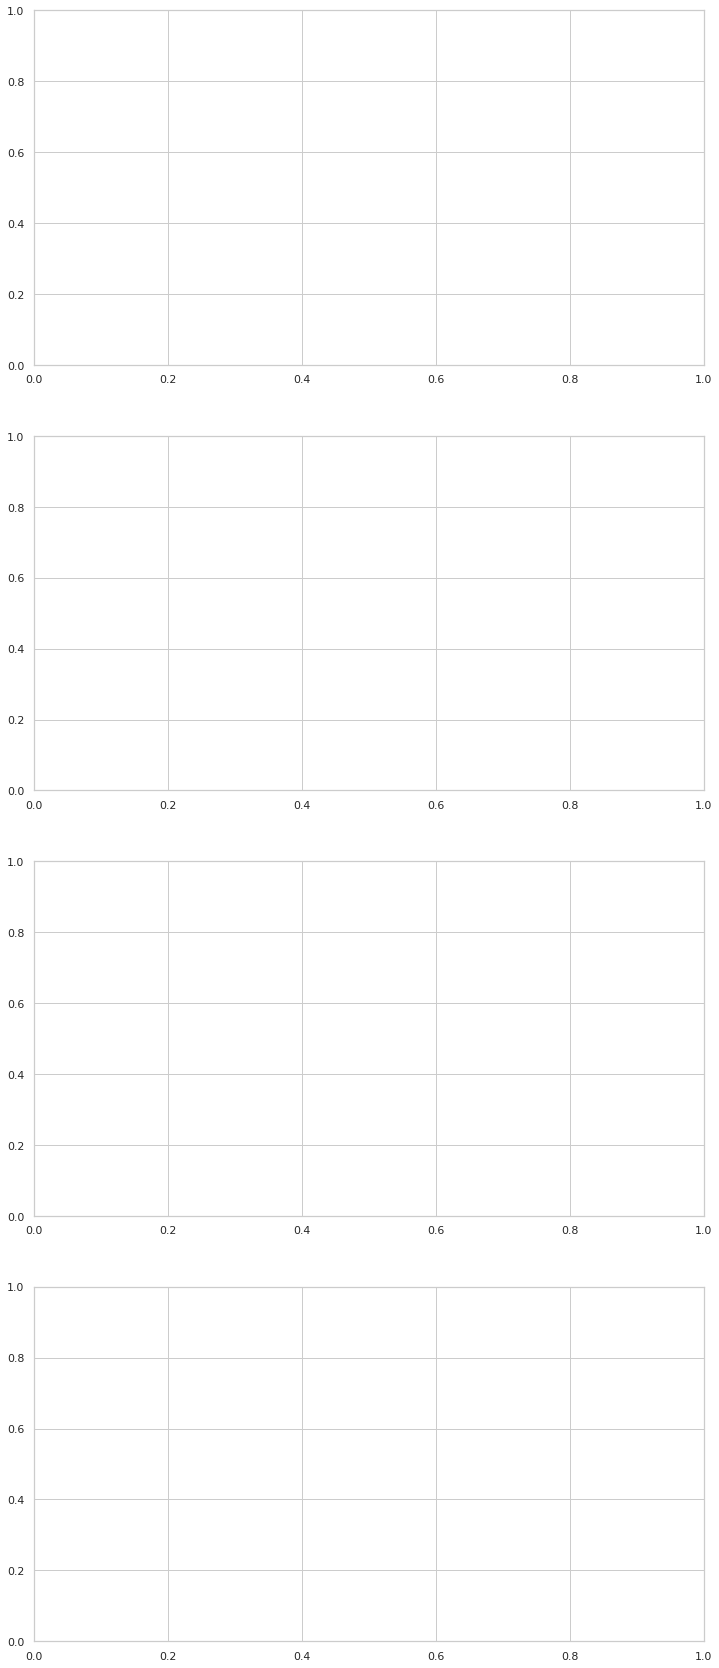

In [11]:
for well in tqdm(np.unique(data.WELL)):
    draw_scaled(data, well)

In [307]:
for well in tqdm(np.unique(data.WELL)):
    draw_sub(data, well)

100%|██████████████████████████████████████████████████████████████████| 134/134 [02:23<00:00,  1.07s/it]


<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

## Draw prod rate

In [15]:
for well in tqdm(np.unique(data.WELL)):
    draw_prod_rate(data, well, name_prefix="")

100%|█████████████████████████████████████████| 134/134 [01:31<00:00,  1.47it/s]


<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

## Try sliding window

In [308]:
def slided(data, window=3):
    data = data.copy(deep=True)
    columns = ["WWPR", "WOPR", "WGPR", "WGIR", "WWIR", "WBHP", "WTHP"]
    for well in tqdm(np.unique(data.WELL)):
        indexes = (data.WELL == well) & filter_all(data)
        cur_data = data[indexes].fillna(0)
        for i, c in enumerate(columns):
            data.loc[indexes, [c]] = list(
                cur_data[c].rolling(window, min_periods=1, center=True).mean()
            )
    return data


def sub(data, data_slided):
    data = data.copy(deep=True)
    columns = ["WWPR", "WOPR", "WGPR", "WGIR", "WWIR", "WBHP", "WTHP"]
    data.loc[:, columns] = data.loc[:, columns] - data_slided7.loc[:, columns]
    return data

In [309]:
data_slided7 = slided(data, window=7)
for well in tqdm(np.unique(data.WELL)):
    draw_sub(data_slided7, well, name_prefix="slided_7_")

100%|██████████████████████████████████████████████████████████████████| 134/134 [02:24<00:00,  1.08s/it]


<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

In [310]:
data_sub7 = sub(data, data_slided7)
for well in tqdm(np.unique(data.WELL)):
    draw_sub(data_sub7, well, name_prefix="sub_7_")

100%|██████████████████████████████████████████████████████████████████| 134/134 [02:29<00:00,  1.11s/it]


<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

In [311]:
data_slided3 = slided(data, window=3)
for well in tqdm(np.unique(data.WELL)):
    draw_sub(data_slided3, well, name_prefix="slided_3_")

100%|██████████████████████████████████████████████████████████████████| 134/134 [02:24<00:00,  1.08s/it]


<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

In [312]:
data_sub3 = sub(data, data_slided3)
for well in tqdm(np.unique(data.WELL)):
    draw_sub(data_sub3, well, name_prefix='sub_3_')

100%|██████████████████████████████████████████████████████████████████| 134/134 [02:23<00:00,  1.07s/it]


<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>